# With Technical Indicators Version (933 episodes)

In this version, the agent uses close price value, the difference in close prices from the previous trading day, and 8 technical indicators as the state for predicting actions (buy or sell).<br>

The parameters for this baseline version are as follows:<br>
WINDOW_SIZE: 14<br>
train_df: 2,142<br>
test_df: 814<br>
total_timesteps: 2,000,000<br>
episodes: 933

## WithTechIndicators

### Pip Install Commands

In [173]:
%pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Libraries

In [174]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from gym_anytrading.envs import StocksEnv
from finta import TA

from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

### Constant Values

In [175]:
WINDOW_SIZE = 14
DATASET_PATH = '/content/TSLA.csv'

### Methods

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = env.df.loc[:, [
        'Close',
        'SMA', 
        'RSI', 
        'MOM', 
        'OBV', 
        'EMA', 
        'Stochastic oscillator', 
        'AD', 
        'ROC']].to_numpy()[start:end]
    
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    signal_features = np.concatenate((signal_features, diff_reshaped), axis=1)

    return prices, signal_features

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [ ]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

    def reset(self, seed=None, options=None):
      super().reset(seed=seed, options=options)
      self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

      self._truncated = False
      self._current_tick = self._start_tick
      self._last_trade_tick = self._current_tick - 1
      self._position = Positions.Short
      self._position_history = (self.window_size * [None]) + [self._position]
      self._total_reward = 0.
      self._total_profit = 1000.  # unit
      self._first_rendering = True
      self.history = {}

      observation = self._get_observation()
      info = self._get_info()

      if self.render_mode == 'human':
          self._render_frame()

      return observation, info

In [ ]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=14)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

### Code

Read the dataset and preprocess it

In [176]:
df = pd.read_csv(DATASET_PATH)

In [177]:
df['Date'] = pd.to_datetime(df.Date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [178]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [179]:
df.set_index('Date', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
df.sort_index(inplace=True)

In [181]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [183]:
df['SMA'] = TA.SMA(df, WINDOW_SIZE)
df['RSI'] = TA.RSI(df, WINDOW_SIZE)
df['MOM'] = TA.MOM(df, WINDOW_SIZE)
df['OBV'] = TA.OBV(df,'close')
df['EMA'] = TA.EMA(df, WINDOW_SIZE)
df['Stochastic oscillator'] = TA.AO(df,WINDOW_SIZE)
df['AD'] = TA.ADL(df)
df['ROC'] = TA.ROC(df,WINDOW_SIZE)
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
df.head(50)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,MOM,OBV,EMA,Stochastic oscillator,AD,ROC
Date,,,,,,,,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,0.000000,0.000000,0.000,0.0,4.778000,0.000000,6.590845e+07,0.000000
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0.000000,0.000000,0.000,-85935500.0,4.771571,0.000000,-7.233279e+06,0.000000
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0.000000,0.000000,0.000,-127029500.0,4.626574,0.000000,-2.374361e+07,0.000000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,0.000000,0.000000,0.000,-152728500.0,4.385939,0.000000,-4.370570e+07,0.000000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,0.000000,0.000000,0.000,-187063000.0,4.082269,0.000000,-7.342934e+07,0.000000
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500,0.000000,0.000000,0.000,-221671500.0,3.868872,0.000000,-7.363909e+07,0.000000
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000,0.000000,20.112173,0.000,-183114500.0,3.789457,0.000000,-3.745482e+07,0.000000
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000,0.000000,19.955945,0.000,-203367500.0,3.728932,0.000000,-3.220405e+07,0.000000
2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500,0.000000,19.027444,0.000,-214380000.0,3.670209,0.000000,-4.218734e+07,0.000000


Spilt the dataset for training and testing

In [188]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  2142
test_df:  814


In [189]:
train_df.shape

(2142, 14)

Create a log directory

In [190]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

Create a trading environment for training the agent on

In [191]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

env = Monitor(env, log_dir)

A vector the agent will use to predict the action (buy or sell)

In [192]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[4.77800000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.77800000e+00, 0.00000000e+00, 6.59084531e+07,
        0.00000000e+00, 0.00000000e+00]])

In [193]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. <br>
Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [194]:
env.action_space.sample()

1

Sell = 0

Buy = 1

In [195]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (14, 10), float32)

Box: describes an n-dimensional continuous space. <br>
It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.

In [196]:
env.observation_space.sample()

array([[ 4.88584000e+08, -2.92694835e+09, -9.72972954e+09,
         4.29197747e+09,  7.01902746e+09,  6.25894400e+08,
        -8.37191168e+09, -5.31628851e+09,  2.17308000e+08,
        -1.05741050e+09],
       [-3.63635610e+09, -7.26483712e+09,  5.69987072e+09,
        -9.17373952e+09,  1.12967987e+09,  9.30964685e+09,
         2.07105766e+09,  8.10444083e+09,  3.20730368e+09,
        -6.94139802e+09],
       [-3.19780659e+09,  9.43246131e+09,  4.81404621e+09,
         8.63512166e+09,  4.04996147e+09,  3.26791040e+08,
         4.39769139e+09,  6.79985510e+09, -5.99239322e+09,
         9.68443290e+09],
       [-8.04325888e+09, -6.48545229e+09,  2.92657152e+08,
         7.30415872e+08,  2.08880256e+08,  8.03459123e+09,
         9.12253030e+09, -5.39445376e+08,  2.11619341e+09,
        -4.91049856e+08],
       [ 8.16937062e+09, -2.20665267e+09,  5.43630387e+09,
         2.57532493e+09, -4.43491123e+09,  2.87669408e+08,
        -8.08360499e+09, -9.92288768e+09, -4.96307046e+09,
        -8.

Create the environment and some random action on it

info: {'total_reward': 45.983995000000014, 'total_profit': 0.004284681837425818, 'position': <Positions.Short: 0>, 'episode': {'r': 45.983995, 'l': 2127, 't': 0.111684}}


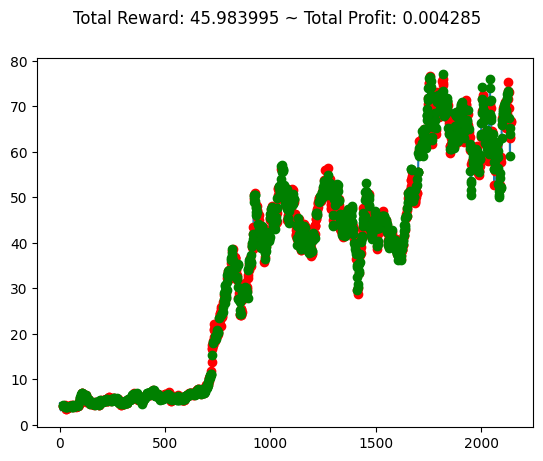

In [197]:
observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

Create and training the model for 200 episodes or epochs

In [198]:
model = A2C("MlpPolicy", env, verbose=1)

# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=2142, log_dir=log_dir)

# Train the model
model.learn(total_timesteps=2000000,callback=callback)

Streaming output truncated to the last 5000 lines.
|    ep_rew_mean        | 92.1     |
| time/                 |          |
|    fps                | 492      |
|    iterations         | 371600   |
|    time_elapsed       | 3771     |
|    total_timesteps    | 1858000  |
| train/                |          |
|    entropy_loss       | -0.214   |
|    explained_variance | -3.17    |
|    learning_rate      | 0.0007   |
|    n_updates          | 371599   |
|    policy_loss        | -0.00414 |
|    value_loss         | 0.00522  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.13e+03 |
|    ep_rew_mean        | 92.1     |
| time/                 |          |
|    fps                | 492      |
|    iterations         | 371700   |
|    time_elapsed       | 3771     |
|    total_timesteps    | 1858500  |
| train/                |          |
|    entropy_loss       | -0.0784  |
|    explained_variance 

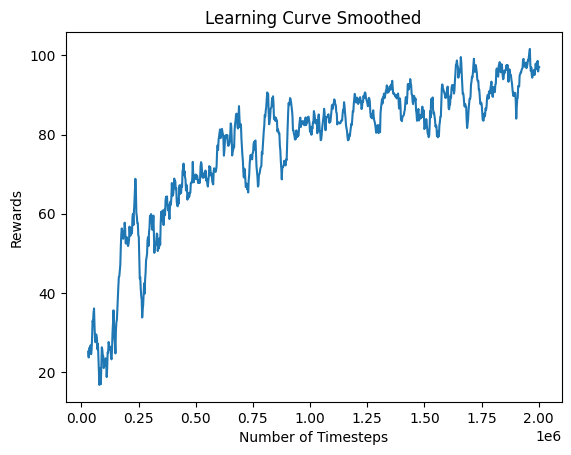

In [201]:
plot_results(log_dir)

Evaluate the model for 5 repetitions

info: {'total_reward': 544.206021, 'total_profit': 6.099227252580531, 'position': <Positions.Long: 1>}


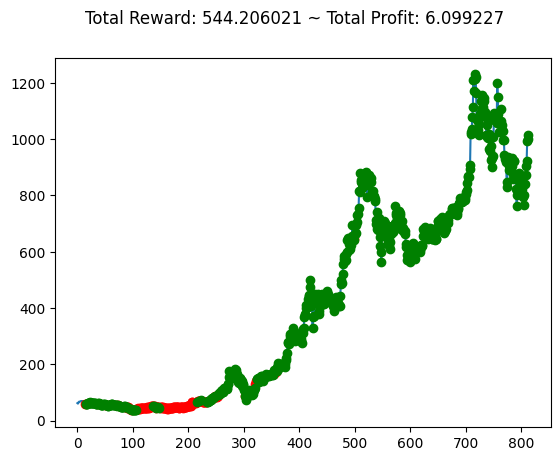

Sharpe Ratio: 1.3466172543445893
info: {'total_reward': 134.75203100000004, 'total_profit': 8.129678266168039, 'position': <Positions.Long: 1>}


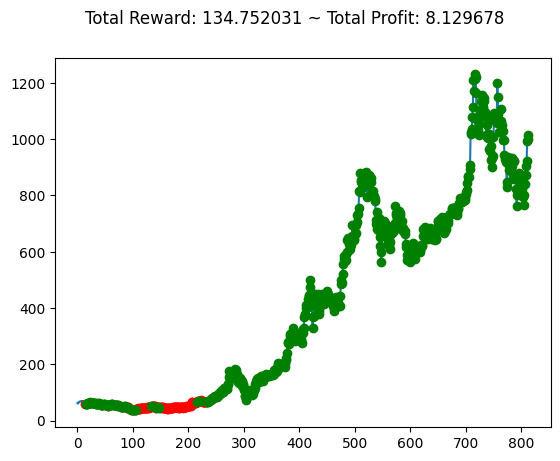

Sharpe Ratio: 2.475487640287649
info: {'total_reward': 553.1720420000001, 'total_profit': 6.930324736960574, 'position': <Positions.Long: 1>}


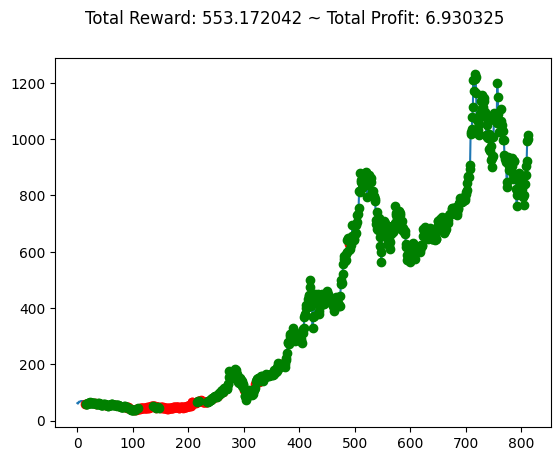

Sharpe Ratio: 1.4391098595746494
info: {'total_reward': 589.064067, 'total_profit': 8.034593844572255, 'position': <Positions.Long: 1>}


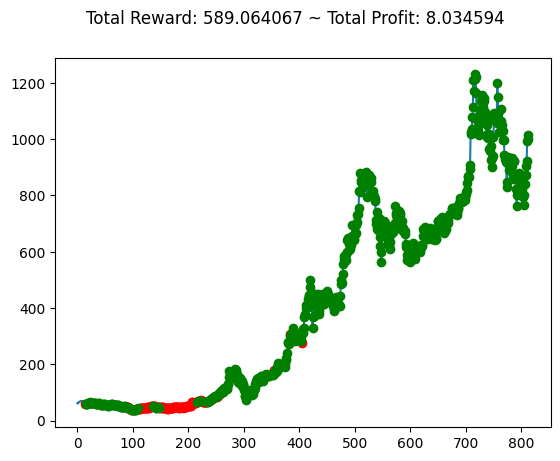

Sharpe Ratio: 1.3813423710167623
info: {'total_reward': 58.89202600000003, 'total_profit': 7.6456067304004804, 'position': <Positions.Long: 1>}


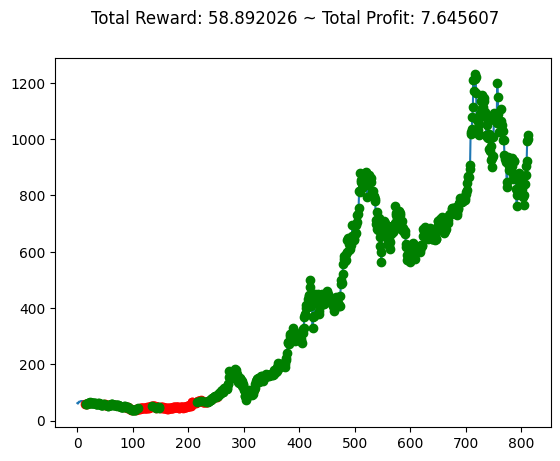

Sharpe Ratio: 3.213505132244705


In [205]:
total_profit_list = []
total_reward_list = []
total_sharpe_ratio_list = []

for i in range(5):

  env = MyCustomEnv(df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset(seed=2024)
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          total_profit_list.append(info['total_profit'])
          total_reward_list.append(info['total_reward'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

  AWR = env.history['total_profit']

  average_sharpe_ratio = np.mean(AWR) / np.std(AWR)
  print('Sharpe Ratio:', average_sharpe_ratio)
  total_sharpe_ratio_list.append(average_sharpe_ratio)



In [206]:
print('average sharpe ratio: ',np.mean(total_sharpe_ratio_list))
print('average profit: ',np.mean(total_profit_list))

average sharpe ratio:  1.971212451493671
average profit:  7.367886166136375


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
